# Ensemble Learning Tutorial

This tutorial is based on the practical exercises from Chapter 7 of "Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow" by Aurélien Géron, 2019.

## Voting Classifiers

Let's build a voting classifier, using Random Forests, Support Vector Machines and Logistic Regression as base learners:

In [30]:
# Load packages and toy dataset
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Toy dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)

# Train voting classifier
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Check the invididual accuracies of the base learners on test data:

In [2]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


Make a prediction using the voting classifier for the first test data point:

In [44]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

Check the individual precitions of the base learners:

In [45]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

Check the score of the voting classifier on the entire test dataset (using a hard-voting strategy):

In [5]:
voting_clf.score(X_test, y_test)

0.912

Compare with a soft-voting strategy, based on the probabilities from each classifier. To achive this, SVMs have to be retrained with a different hyperparameter:

In [46]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging

Let's create a bagging classifier using 500 decision trees, each with a maximum of 100 samples.

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

To get an estimate of the accuracy of the model using the Out-of-Bag samples, we need to retrain using the oob_score=True hyperparameter:

In [47]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

# OOB evaluation
bag_clf.oob_score_

0.896

Check the first 3 individual OOB predictions:

In [51]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

Calculate the accuracy of the bagging classifier on the entire test data:

In [52]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

## Random Forests

Now let's try Random Forests. Let's start by using 500 trees in the forest and a maximum of leaf nodes = 16.

In [108]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

Calculate test accuracy:

In [55]:
accuracy_score(y_test, y_pred_rf)

0.912

Random Forests is equivalent to creating a Bagging Classifier:

In [56]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred_bg = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_bg)

0.912

Confirm that the predictions of these two models are identical:

In [58]:
import numpy as np
np.all(y_pred_bg == y_pred_rf)  # same predictions

True

### Feature Importance

Let's work on a more realistic example (the Iris dataset) and plot the feature importance attribute of Random Forests:

In [59]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Plot feature importance for Random Forest classifier:

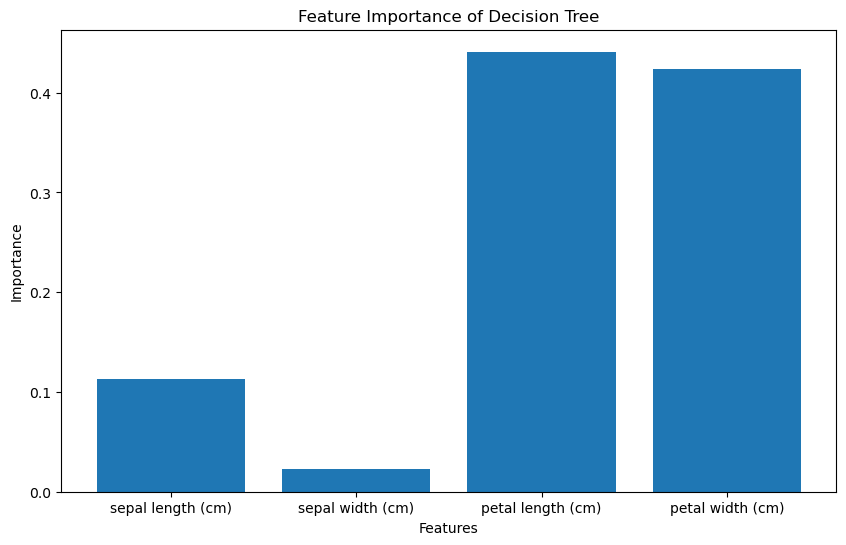

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(rnd_clf.feature_importances_)), rnd_clf.feature_importances_, tick_label=iris.feature_names)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Decision Tree')
plt.show()

## Boosting

### AdaBoost

Now let's create a Boosting classifier:

In [75]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_train)

# Accuracy on training data
accuracy_score(y_train, y_pred_ada)

0.9013333333333333

In [76]:
# Calculate accuracy on the test data
y_pred_ada = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada)

0.88

### Gradient Boosting

The following example of Gradient Boosting relates to Figure 7-9 of Chapter 7 "Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow" by Aurélien Géron, 2019.

The dataset is synthetically generated below:

In [90]:
import numpy as np

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

Plot data:

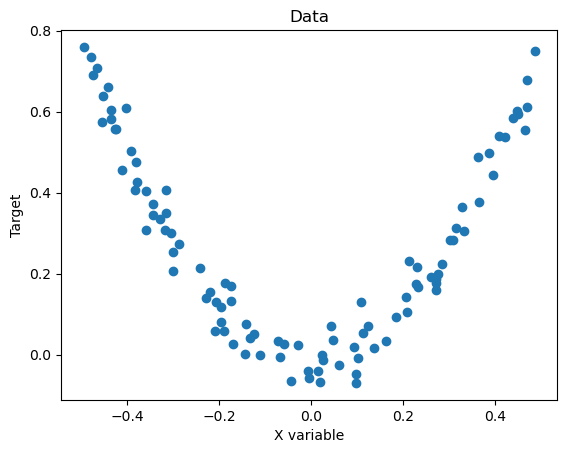

In [91]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.xlabel('X variable')
plt.ylabel('Target')
plt.title('Data')
plt.show()


Create and train first regression tree:

In [92]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Create and train second tree:

In [93]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

Create and train third tree:

In [94]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Make prediction on a new data point:

In [95]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

The following code recreates Figure 7-9.

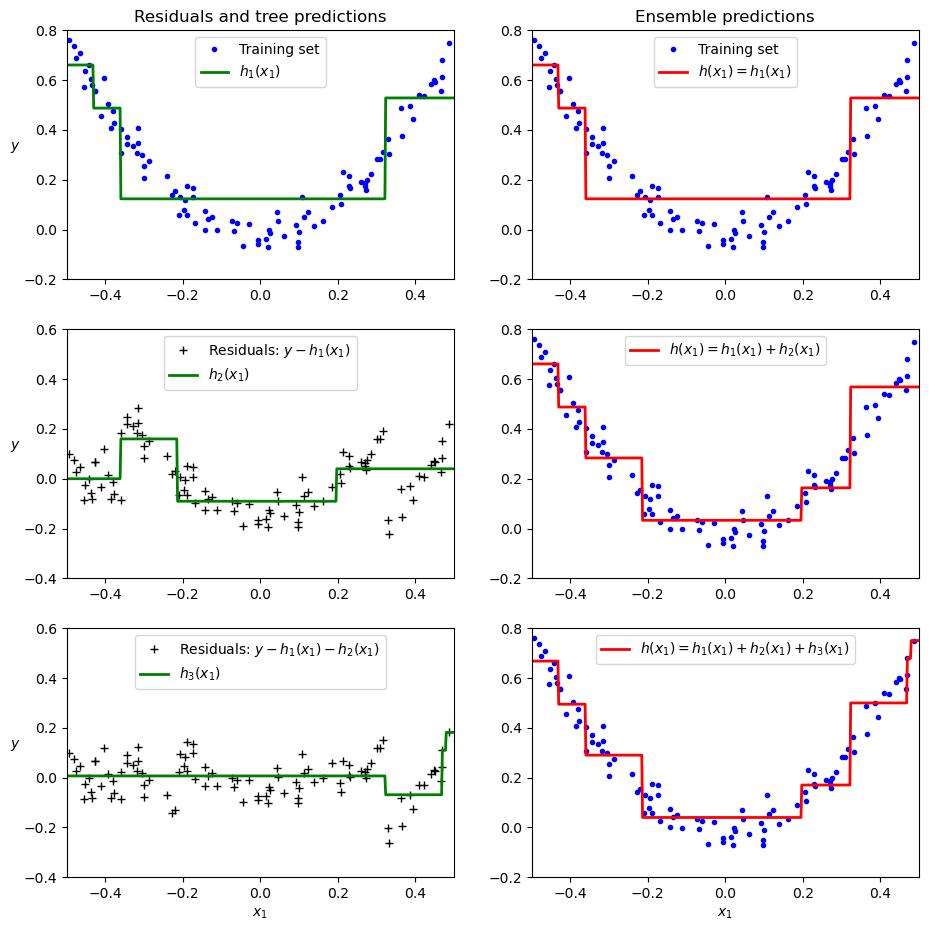

In [100]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)
   

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

Now let's try a gradient boosting regressor:

In [101]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

Calculate R2 score:

In [102]:
gbrt.score(X,y)

0.9095502641012175

Reduce learning rate and increase the number of trees to achieve better results:

In [105]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

gbrt_best.score(X,y)

0.9759700529797392

Check which individual tree was the best estimator:

In [26]:
gbrt_best.n_estimators_

92

## Stacking

Finally let's take a look at stacking. The following lines of code implement a stacking classifier using Logistic Regression, Random Forests and Support Vector Machines as base individual classifiers, and then a Random Forest classifier on top:

In [106]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

Calculate the test accuracy:

In [107]:
stacking_clf.score(X_test, y_test)

0.928